## Equally Weighted

In [34]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

# === Model list (make sure the pred file contains these columns) ===
models = ["ols", "ols_reduced", "lasso", "ridge", "xgb", "ae_ridge"]

# === Load data ===
pred = pd.read_csv("../results/prediction_results.csv")     # Contains 'year', 'month', 'permno', 'stock_exret', and model predictions
mkt = pd.read_csv("../data/raw/mkt_ind.csv")                 # Contains 'year', 'month', 'mkt_rf', 'rf'

for model in models:
    print(f"\n=== Evaluating model: {model} ===")

    # === Construct long-short portfolio: top 50 and bottom 50 based on model score each month ===
    def construct_fixed_portfolio(df_month):
        df_month = df_month.dropna(subset=[model, "stock_exret"]).sort_values(model)
        if len(df_month) < 100:
            return pd.DataFrame()  # Skip months with insufficient stocks
        long_leg = df_month.iloc[-50:].copy()
        long_leg["side"] = "long"
        short_leg = df_month.iloc[:50].copy()
        short_leg["side"] = "short"
        return pd.concat([long_leg, short_leg])

    portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)

    # === Calculate long-short return each month ===
    long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"])["stock_exret"].mean()
    short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"])["stock_exret"].mean()

    monthly_port = pd.DataFrame({
        "year": long_ret.index.get_level_values(0),
        "month": long_ret.index.get_level_values(1),
        "port_11": long_ret.values - short_ret.values
    })

    # === Merge with market factor data ===
    monthly_port = monthly_port.merge(mkt, how="inner", on=["year", "month"])

    # === CAPM regression with HAC standard errors ===
    nw_ols = sm.ols(formula="port_11 ~ rf", data=monthly_port).fit(
        cov_type="HAC", cov_kwds={"maxlags": 3}, use_t=True
    )

    # === Output key performance metrics ===
    sharpe = monthly_port["port_11"].mean() / monthly_port["port_11"].std() * np.sqrt(12)
    print("Sharpe Ratio:", sharpe)

    print(nw_ols.summary())
    print("CAPM Alpha:", nw_ols.params["Intercept"])
    print("t-statistic:", nw_ols.tvalues["Intercept"])
    print("Information Ratio:", nw_ols.params["Intercept"] / np.sqrt(nw_ols.mse_resid) * np.sqrt(12))

    # === Maximum drawdown and worst single-month loss ===
    monthly_port["log_port_11"] = np.log(monthly_port["port_11"] + 1)
    monthly_port["cumsum_log_port_11"] = monthly_port["log_port_11"].cumsum()
    peak = monthly_port["cumsum_log_port_11"].cummax()
    drawdown = peak - monthly_port["cumsum_log_port_11"]
    print("Max Drawdown:", drawdown.max())
    print("Max Monthly Loss:", monthly_port["port_11"].min())


=== Evaluating model: ols ===


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_13632\3795040111.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)


Sharpe Ratio: 0.39510814554350354
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.199
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.275
Time:                        08:14:30   Log-Likelihood:                 275.32
No. Observations:                 168   AIC:                            -546.6
Df Residuals:                     166   BIC:                            -540.4
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_13632\3795040111.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)


Sharpe Ratio: 0.5417375358741088
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.09001
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.765
Time:                        08:14:31   Log-Likelihood:                 273.92
No. Observations:                 168   AIC:                            -543.8
Df Residuals:                     166   BIC:                            -537.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.00

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_13632\3795040111.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)


Sharpe Ratio: -0.5275984050896153
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2022
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.654
Time:                        08:14:31   Log-Likelihood:                 295.03
No. Observations:                 168   AIC:                            -586.1
Df Residuals:                     166   BIC:                            -579.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_13632\3795040111.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)


Sharpe Ratio: 0.45548139771210855
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.6537
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.420
Time:                        08:14:32   Log-Likelihood:                 257.23
No. Observations:                 168   AIC:                            -510.5
Df Residuals:                     166   BIC:                            -504.2
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_13632\3795040111.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)


Sharpe Ratio: 0.12086888344176631
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1923
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.662
Time:                        08:14:32   Log-Likelihood:                 279.39
No. Observations:                 168   AIC:                            -554.8
Df Residuals:                     166   BIC:                            -548.5
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_13632\3795040111.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)


In [37]:
# === Step 1: Import and Load Data ===
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load prediction and benchmark data
df = pd.read_csv("../results/prediction_results.csv")
benchmark = pd.read_csv("../data/raw/mkt_ind.csv")
benchmark["yyyymm"] = benchmark["year"] * 100 + benchmark["month"]
benchmark["mkt_rf"] = benchmark["sp_ret"] - benchmark["rf"]
benchmark = benchmark.set_index("yyyymm")

# === Step 2: Define Score Combinations ===
score_defs = {
    "ols_only": df["ols"],
    "ols_reduced": df["ols_reduced"],
    "surprise_only": df["pred_surprise"],
    "ols_plus_surprise": df["ols"] + df["pred_surprise"],
    "lasso_only": df["lasso"],
    "lasso_plus_surprise": df["lasso"] + df["pred_surprise"],
    "ridge_only": df["ridge"],
    "ridge_plus_surprise": df["ridge"] + df["pred_surprise"],
    "xgb_only": df["xgb"],
    "xgb_plus_surprise": df["xgb"] + df["pred_surprise"],
    "ae_ridge": df["ae_ridge"],
    "ae_plus_surprise": df["ae_ridge"] + df["pred_surprise"]
}

# === Step 3: Construct Equally Weighted Long-Short Portfolio (Q4 - Q0) ===
def construct_longshort_portfolio(df, score_col, ret_col="stock_exret"):
    df = df[["permno", "yyyymm", ret_col, score_col]].dropna().copy()
    df["score"] = df[score_col]
    df["rank"] = df.groupby("yyyymm")["score"].transform(
        lambda x: pd.qcut(x.rank(method="first"), 5, labels=False, duplicates="drop")
    )
    monthly_returns = df.groupby(["yyyymm", "rank"])[ret_col].mean().unstack().dropna()
    if 0 not in monthly_returns.columns or 4 not in monthly_returns.columns:
        raise ValueError(f"[ERROR] {score_col}: missing quintile 0 or 4")
    long_short = monthly_returns[4] - monthly_returns[0]
    long_short.name = score_col
    return long_short

# === Step 4: Run CAPM Regression for Performance Metrics ===
def compute_regression_metrics(ret_series, benchmark_df, score_name):
    # Convert index to yyyymm
    ret_series.index = pd.to_datetime(ret_series.index)
    ret_series.index = ret_series.index.year * 100 + ret_series.index.month

    df = pd.DataFrame({score_name: ret_series}).join(benchmark_df, how="inner")

    if df.empty:
        raise ValueError(f"[ERROR] {score_name} → merged dataframe is empty.")

    df["excess_ret"] = df[score_name] - df["rf"]
    X = sm.add_constant(df["mkt_rf"])
    y = df["excess_ret"]

    model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

    alpha = model.params["const"]
    alpha_t = model.tvalues["const"]
    beta = model.params["mkt_rf"]
    ir = alpha / np.sqrt(model.mse_resid) * np.sqrt(12)
    sharpe = y.mean() / y.std() * np.sqrt(12)
    ann_ret = df[score_name].mean() * 12
    ann_vol = df[score_name].std() * np.sqrt(12)

    cum_ret = (1 + df[score_name]).cumprod()
    peak = cum_ret.cummax()
    drawdown = (cum_ret - peak) / peak
    max_drawdown = drawdown.min()

    return {
        "Score": score_name,
        "Annualized Return": ann_ret,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Alpha": alpha,
        "Alpha t-stat": alpha_t,
        "Beta": beta,
        "Information Ratio": ir,
        "Max Drawdown": max_drawdown,
        "Max Monthly Loss": df[score_name].min()
    }

# === Step 5: Loop Over All Models and Output Table ===
metrics_list = []
for score_name, score_series in score_defs.items():
    df[score_name] = score_series
    ret_series = construct_longshort_portfolio(df, score_name)
    metrics = compute_regression_metrics(ret_series, benchmark, score_name)
    metrics_list.append(metrics)

final_metrics_df = pd.DataFrame(metrics_list).set_index("Score")
print(final_metrics_df.round(4))

                     Annualized Return  Annualized Volatility  Sharpe Ratio  \
Score                                                                         
ols_only                        0.0201                 0.0844        0.1376   
ols_reduced                     0.0515                 0.0993        0.4316   
surprise_only                   0.0092                 0.1328        0.0076   
ols_plus_surprise               0.0292                 0.1069        0.1963   
lasso_only                     -0.0222                 0.0791       -0.3850   
lasso_plus_surprise             0.0087                 0.1313        0.0040   
ridge_only                      0.0511                 0.1201        0.3543   
ridge_plus_surprise             0.0201                 0.1302        0.0911   
xgb_only                        0.0226                 0.0879        0.1596   
xgb_plus_surprise               0.0177                 0.0931        0.1020   
ae_ridge                        0.0374              

In [61]:
# === Final unified version: enhanced score + equally weighted + dynamic spread threshold ===
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load data
df = pd.read_csv("../results/prediction_results.csv")
benchmark = pd.read_csv("../data/raw/mkt_ind.csv")
benchmark["yyyymm"] = benchmark["year"] * 100 + benchmark["month"]
benchmark["mkt_rf"] = benchmark["sp_ret"] - benchmark["rf"]
benchmark = benchmark.set_index("yyyymm")

# Build enhanced scores
def build_enhanced_score(df, ret_col, surprise_col):
    enhanced = df[ret_col].copy()
    mask = df[surprise_col].notna()
    enhanced[mask] = 1.5 * df.loc[mask, ret_col] + 0.3 * df.loc[mask, ret_col] * df.loc[mask, surprise_col]
    return enhanced

df["ols_reduced_enhanced"] = build_enhanced_score(df, "ols_reduced", "pred_surprise")
df["ridge_enhanced"] = build_enhanced_score(df, "ridge", "pred_surprise")
df["ols_enhanced"] = build_enhanced_score(df, "ols", "pred_surprise")

models = ["ols_reduced", "ridge", "ols",
          "ols_reduced_enhanced", "ridge_enhanced", "ols_enhanced"]

# Construct equally weighted long-short portfolio with dynamic threshold
def dynamic_equal_weight_portfolio(df, model):
    portfolio_list = []
    last_portfolio = None
    first_built = False
    spread_list = []

    for (y, m), df_month in df.groupby(["year", "month"]):
        df_month = df_month.dropna(subset=[model, "stock_exret"])
        if len(df_month) < 100:
            continue
        top50 = df_month[model].nlargest(50)
        bottom50 = df_month[model].nsmallest(50)
        spread = top50.mean() - bottom50.mean()
        spread_list.append(spread)

    if not spread_list:
        print(f"Model {model}: No spread data.")
        return pd.DataFrame(columns=df.columns.tolist() + ["side", "year", "month"])

    threshold = np.percentile(spread_list, 20)
    print(f"Model {model}: Dynamic threshold = {threshold:.4f}")

    for (y, m), df_month in df.groupby(["year", "month"]):
        df_month = df_month.dropna(subset=[model, "stock_exret"]).sort_values(model)
        if len(df_month) < 100:
            continue
        spread = df_month[model].nlargest(50).mean() - df_month[model].nsmallest(50).mean()

        if not first_built or spread >= threshold:
            long_leg = df_month.iloc[-50:].copy()
            long_leg["side"] = "long"
            short_leg = df_month.iloc[:50].copy()
            short_leg["side"] = "short"
            combined = pd.concat([long_leg, short_leg])
            combined["year"] = y
            combined["month"] = m
            portfolio_list.append(combined)
            last_portfolio = combined.copy()
            first_built = True
        else:
            reused = last_portfolio.copy()
            reused["year"] = y
            reused["month"] = m
            portfolio_list.append(reused)

    return pd.concat(portfolio_list, ignore_index=True)

# Evaluate equally weighted returns
def run_backtest_equal_weight(df, model, benchmark):
    portfolio_df = dynamic_equal_weight_portfolio(df, model)

    long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"])["stock_exret"].mean()
    short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"])["stock_exret"].mean()

    monthly_port = pd.DataFrame({
        "year": long_ret.index.get_level_values(0),
        "month": long_ret.index.get_level_values(1),
        "port_11": long_ret.values - short_ret.values
    })
    monthly_port["yyyymm"] = monthly_port["year"] * 100 + monthly_port["month"]
    monthly_port = monthly_port.merge(benchmark, left_on="yyyymm", right_index=True)

    model_fit = sm.OLS(monthly_port["port_11"] - monthly_port["rf"],
                       sm.add_constant(monthly_port["mkt_rf"])).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

    sharpe = (monthly_port["port_11"] - monthly_port["rf"]).mean() / \
             (monthly_port["port_11"] - monthly_port["rf"]).std() * np.sqrt(12)
    alpha = model_fit.params["const"]
    alpha_t = model_fit.tvalues["const"]
    ir = alpha / np.sqrt(model_fit.mse_resid) * np.sqrt(12)

    cum_ret = (1 + monthly_port["port_11"]).cumprod()
    peak = cum_ret.cummax()
    drawdown = (cum_ret - peak) / peak
    max_dd = drawdown.min()
    max_loss = monthly_port["port_11"].min()

    # Annualized return and std (based on total portfolio return)
    avg_ret = monthly_port["port_11"].mean()
    std_ret = monthly_port["port_11"].std()
    ann_return = avg_ret * 12
    ann_vol = std_ret * np.sqrt(12)

    # Turnover: percent of new stocks each month
    turnover_list = []
    last_set = set()
    for (y, m), df_month in portfolio_df.groupby(["year", "month"]):
        current_set = set(df_month["permno"])
        if last_set:
            turnover = 1 - len(current_set & last_set) / 100  # fixed 100 stock size
            turnover_list.append(turnover)
        last_set = current_set
    avg_turnover = np.mean(turnover_list)


    return {
        "Model": model,
        "Sharpe": sharpe,
        "Alpha": alpha,
        "Alpha (Annualized)": alpha * 12,
        "Alpha t-stat": alpha_t,
        "IR": ir,
        "Annualized Return": ann_return,
        "Annualized Vol": ann_vol,
        "Turnover": avg_turnover,
        "Max Drawdown": max_dd,
        "Max Monthly Loss": max_loss
    }

# Run evaluation for all models
results = []
for model in models:
    print(f"\n=== Evaluating model with enhanced signal and equal weight: {model} ===")
    metrics = run_backtest_equal_weight(df, model, benchmark)
    results.append(metrics)

# Display results
results_df = pd.DataFrame(results).set_index("Model")
print(results_df.round(4))


=== Evaluating model with enhanced signal and equal weight: ols_reduced ===
Model ols_reduced: Dynamic threshold = 0.0300

=== Evaluating model with enhanced signal and equal weight: ridge ===
Model ridge: Dynamic threshold = 0.0011

=== Evaluating model with enhanced signal and equal weight: ols ===
Model ols: Dynamic threshold = 0.0455

=== Evaluating model with enhanced signal and equal weight: ols_reduced_enhanced ===
Model ols_reduced_enhanced: Dynamic threshold = 0.0449

=== Evaluating model with enhanced signal and equal weight: ridge_enhanced ===
Model ridge_enhanced: Dynamic threshold = 0.0023

=== Evaluating model with enhanced signal and equal weight: ols_enhanced ===
Model ols_enhanced: Dynamic threshold = 0.0682
                      Sharpe   Alpha  Alpha (Annualized)  Alpha t-stat  \
Model                                                                    
ols_reduced           0.6224  0.0079              0.0946        1.5941   
ridge                 0.5679  0.0091      

In [58]:
# === Final Version: Direct Add Surprise + Equal Weight Portfolio Strategy ===
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load prediction and market data
df = pd.read_csv("../results/prediction_results.csv")
benchmark = pd.read_csv("../data/raw/mkt_ind.csv")
benchmark["yyyymm"] = benchmark["year"] * 100 + benchmark["month"]
benchmark["mkt_rf"] = benchmark["sp_ret"] - benchmark["rf"]
benchmark = benchmark.set_index("yyyymm")

# === Build direct-add surprise signals ===
df["ols_reduced_plus"] = df["ols_reduced"] + df["pred_surprise"]
df["ridge_plus"] = df["ridge"] + df["pred_surprise"]
df["ols_plus"] = df["ols"] + df["pred_surprise"]
plus_models = ["ols_reduced_plus", "ridge_plus", "ols_plus"]

# === Equal-weighted dynamic long-short portfolio ===
def dynamic_equal_weight_portfolio(df, model):
    portfolio_list = []
    last_portfolio = None
    first_built = False
    spread_list = []

    for (y, m), df_month in df.groupby(["year", "month"]):
        df_month = df_month.dropna(subset=[model, "stock_exret"])
        if len(df_month) < 100:
            continue
        top50 = df_month[model].nlargest(50)
        bottom50 = df_month[model].nsmallest(50)
        spread = top50.mean() - bottom50.mean()
        spread_list.append(spread)

    if not spread_list:
        print(f"Model {model}: No spread data.")
        return pd.DataFrame(columns=df.columns.tolist() + ["side", "year", "month"])

    threshold = np.percentile(spread_list, 20)
    print(f"Model {model}: Dynamic threshold = {threshold:.4f}")

    for (y, m), df_month in df.groupby(["year", "month"]):
        df_month = df_month.dropna(subset=[model, "stock_exret"]).sort_values(model)
        if len(df_month) < 100:
            continue
        spread = df_month[model].nlargest(50).mean() - df_month[model].nsmallest(50).mean()

        if not first_built or spread >= threshold:
            long_leg = df_month.iloc[-50:].copy()
            long_leg["side"] = "long"
            short_leg = df_month.iloc[:50].copy()
            short_leg["side"] = "short"
            combined = pd.concat([long_leg, short_leg])
            combined["year"] = y
            combined["month"] = m
            portfolio_list.append(combined)
            last_portfolio = combined.copy()
            first_built = True
        else:
            reused = last_portfolio.copy()
            reused["year"] = y
            reused["month"] = m
            portfolio_list.append(reused)

    return pd.concat(portfolio_list, ignore_index=True)

# === Performance evaluation ===
def run_backtest_equal_weight(df, model, benchmark):
    portfolio_df = dynamic_equal_weight_portfolio(df, model)

    long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"])["stock_exret"].mean()
    short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"])["stock_exret"].mean()

    monthly_port = pd.DataFrame({
        "year": long_ret.index.get_level_values(0),
        "month": long_ret.index.get_level_values(1),
        "port_11": long_ret.values - short_ret.values
    })
    monthly_port["yyyymm"] = monthly_port["year"] * 100 + monthly_port["month"]
    monthly_port = monthly_port.merge(benchmark, left_on="yyyymm", right_index=True)

    model_fit = sm.OLS(monthly_port["port_11"] - monthly_port["rf"],
                       sm.add_constant(monthly_port["mkt_rf"])).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

    sharpe = (monthly_port["port_11"] - monthly_port["rf"]).mean() / \
             (monthly_port["port_11"] - monthly_port["rf"]).std() * np.sqrt(12)
    alpha = model_fit.params["const"]
    alpha_t = model_fit.tvalues["const"]
    ir = alpha / np.sqrt(model_fit.mse_resid) * np.sqrt(12)

    cum_ret = (1 + monthly_port["port_11"]).cumprod()
    peak = cum_ret.cummax()
    drawdown = (cum_ret - peak) / peak
    max_dd = drawdown.min()
    max_loss = monthly_port["port_11"].min()

    # Annualized return and std (based on total portfolio return)
    avg_ret = monthly_port["port_11"].mean()
    std_ret = monthly_port["port_11"].std()
    ann_return = avg_ret * 12
    ann_vol = std_ret * np.sqrt(12)

    # Turnover: percent of new stocks each month
    turnover_list = []
    last_set = set()
    for (y, m), df_month in portfolio_df.groupby(["year", "month"]):
        current_set = set(df_month["permno"])
        if last_set:
            turnover = 1 - len(current_set & last_set) / 100  # fixed 100 stock size
            turnover_list.append(turnover)
        last_set = current_set
    avg_turnover = np.mean(turnover_list)


    return {
        "Model": model,
        "Sharpe": sharpe,
        "Alpha": alpha,
        "Alpha (Annualized)": alpha * 12,
        "Alpha t-stat": alpha_t,
        "IR": ir,
        "Annualized Return": ann_return,
        "Annualized Vol": ann_vol,
        "Turnover": avg_turnover,
        "Max Drawdown": max_dd,
        "Max Monthly Loss": max_loss
    }

# === Run and display results ===
results = []
for model in plus_models:
    print(f"\n=== Evaluating model with direct-add surprise signal: {model} ===")
    metrics = run_backtest_equal_weight(df, model, benchmark)
    results.append(metrics)

results_df = pd.DataFrame(results).set_index("Model")
print(results_df.round(4))


=== Evaluating model with direct-add surprise signal: ols_reduced_plus ===
Model ols_reduced_plus: Dynamic threshold = 0.0570

=== Evaluating model with direct-add surprise signal: ridge_plus ===
Model ridge_plus: Dynamic threshold = 0.0461

=== Evaluating model with direct-add surprise signal: ols_plus ===
Model ols_plus: Dynamic threshold = 0.0684
                  Sharpe   Alpha  Alpha (Annualized)  Alpha t-stat      IR  \
Model                                                                        
ols_reduced_plus  0.7905  0.0163              0.1956        2.9173  1.0107   
ridge_plus       -0.6150 -0.0075             -0.0897       -1.0812 -0.4110   
ols_plus          0.2093  0.0064              0.0771        1.7457  0.4818   

                  Annualized Return  Annualized Vol  Turnover  Max Drawdown  \
Model                                                                         
ols_reduced_plus             0.1664          0.1998    0.3372       -0.4138   
ridge_plus         

In [85]:
# === Final Full Code: Mixed Enhancement Strategy (Add + Multiply) ===
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load input data
df = pd.read_csv("../results/prediction_results.csv")
benchmark = pd.read_csv("../data/raw/mkt_ind.csv")
benchmark["yyyymm"] = benchmark["year"] * 100 + benchmark["month"]
benchmark["mkt_rf"] = benchmark["sp_ret"] - benchmark["rf"]
benchmark = benchmark.set_index("yyyymm")

# === Step 1: Mixed Score Function (Additive + Multiplicative Surprise) ===
def build_mixed_enhanced_score(df, ret_col, surprise_col, w_add=0.7, w_mul=0.3):
    enhanced = df[ret_col].copy()
    mask = df[surprise_col].notna()
    enhanced[mask] = (
        w_add * (df.loc[mask, ret_col] + df.loc[mask, surprise_col]) +
        w_mul * (df.loc[mask, ret_col] * df.loc[mask, surprise_col])
    )
    return enhanced

# Generate hybrid-enhanced signals
df["ols_reduced_enhanced_mix"] = build_mixed_enhanced_score(df, "ols_reduced", "pred_surprise")
df["ridge_enhanced_mix"] = build_mixed_enhanced_score(df, "ridge", "pred_surprise")
df["ols_enhanced_mix"] = build_mixed_enhanced_score(df, "ols", "pred_surprise")
mixed_models = ["ols_reduced_enhanced_mix", "ridge_enhanced_mix", "ols_enhanced_mix"]

# === Step 2: Portfolio Construction with Dynamic Threshold (Equal Weight) ===
def dynamic_equal_weight_portfolio(df, model):
    portfolio_list = []
    last_portfolio = None
    first_built = False
    spread_list = []

    for (y, m), df_month in df.groupby(["year", "month"]):
        df_month = df_month.dropna(subset=[model, "stock_exret"])
        if len(df_month) < 100:
            continue
        top50 = df_month[model].nlargest(50)
        bottom50 = df_month[model].nsmallest(50)
        spread = top50.mean() - bottom50.mean()
        spread_list.append(spread)

    if not spread_list:
        print(f"Model {model}: No spread data.")
        return pd.DataFrame(columns=df.columns.tolist() + ["side", "year", "month"])

    threshold = np.percentile(spread_list, 20)
    print(f"Model {model}: Dynamic threshold = {threshold:.4f}")

    for (y, m), df_month in df.groupby(["year", "month"]):
        df_month = df_month.dropna(subset=[model, "stock_exret"]).sort_values(model)
        if len(df_month) < 100:
            continue
        spread = df_month[model].nlargest(50).mean() - df_month[model].nsmallest(50).mean()

        if not first_built or spread >= threshold:
            long_leg = df_month.iloc[-50:].copy()
            long_leg["side"] = "long"
            short_leg = df_month.iloc[:50].copy()
            short_leg["side"] = "short"
            combined = pd.concat([long_leg, short_leg])
            combined["year"] = y
            combined["month"] = m
            portfolio_list.append(combined)
            last_portfolio = combined.copy()
            first_built = True
        else:
            reused = last_portfolio.copy()
            reused["year"] = y
            reused["month"] = m
            portfolio_list.append(reused)

    return pd.concat(portfolio_list, ignore_index=True)

# === Step 3: Backtest and Evaluation ===
def run_backtest_equal_weight(df, model, benchmark):
    portfolio_df = dynamic_equal_weight_portfolio(df, model)

    long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"])["stock_exret"].mean()
    short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"])["stock_exret"].mean()

    monthly_port = pd.DataFrame({
        "year": long_ret.index.get_level_values(0),
        "month": long_ret.index.get_level_values(1),
        "port_11": long_ret.values - short_ret.values
    })
    monthly_port["yyyymm"] = monthly_port["year"] * 100 + monthly_port["month"]
    monthly_port = monthly_port.merge(benchmark, left_on="yyyymm", right_index=True)

    model_fit = sm.OLS(monthly_port["port_11"] - monthly_port["rf"],
                       sm.add_constant(monthly_port["mkt_rf"])).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

    sharpe = (monthly_port["port_11"] - monthly_port["rf"]).mean() / \
             (monthly_port["port_11"] - monthly_port["rf"]).std() * np.sqrt(12)
    alpha_val = model_fit.params["const"]
    alpha_t = model_fit.tvalues["const"]
    ir = alpha_val / np.sqrt(model_fit.mse_resid) * np.sqrt(12)

    cum_ret = (1 + monthly_port["port_11"]).cumprod()
    peak = cum_ret.cummax()
    drawdown = (cum_ret - peak) / peak
    max_dd = drawdown.min()
    max_loss = monthly_port["port_11"].min()

    # Annualized return and std (based on total portfolio return)
    avg_ret = monthly_port["port_11"].mean()
    std_ret = monthly_port["port_11"].std()
    ann_return = avg_ret * 12
    ann_vol = std_ret * np.sqrt(12)

    # Turnover: percent of new stocks each month
    turnover_list = []
    last_set = set()
    for (y, m), df_month in portfolio_df.groupby(["year", "month"]):
        current_set = set(df_month["permno"])
        if last_set:
            turnover = 1 - len(current_set & last_set) / 100  # fixed 100 stock size
            turnover_list.append(turnover)
        last_set = current_set
    avg_turnover = np.mean(turnover_list)


    return {
        "Model": model,
        "Sharpe": sharpe,
        "Alpha": alpha_val,
        "Alpha (Annualized)": alpha_val * 12,
        "Alpha t-stat": alpha_t,
        "IR": ir,
        "Annualized Return": ann_return,
        "Annualized Vol": ann_vol,
        "Turnover": avg_turnover,
        "Max Drawdown": max_dd,
        "Max Monthly Loss": max_loss
    }


# === Step 4: Run All Models and Display Results ===
results = []
for model in mixed_models:
    print(f"\n=== Evaluating mixed-enhanced model: {model} ===")
    metrics = run_backtest_equal_weight(df, model, benchmark)
    results.append(metrics)

results_df = pd.DataFrame(results).set_index("Model")
print(results_df.round(4))


=== Evaluating mixed-enhanced model: ols_reduced_enhanced_mix ===
Model ols_reduced_enhanced_mix: Dynamic threshold = 0.0405

=== Evaluating mixed-enhanced model: ridge_enhanced_mix ===
Model ridge_enhanced_mix: Dynamic threshold = 0.0322

=== Evaluating mixed-enhanced model: ols_enhanced_mix ===
Model ols_enhanced_mix: Dynamic threshold = 0.0486
                          Sharpe   Alpha  Alpha (Annualized)  Alpha t-stat  \
Model                                                                        
ols_reduced_enhanced_mix  0.9126  0.0173              0.2080        3.6406   
ridge_enhanced_mix       -0.6319 -0.0076             -0.0915       -1.1083   
ols_enhanced_mix          0.3772  0.0089              0.1068        2.2911   

                              IR  Annualized Return  Annualized Vol  Turnover  \
Model                                                                           
ols_reduced_enhanced_mix  1.1661             0.1780          0.1853    0.3457   
ridge_enhanced_m

Model ols_reduced_enhanced_mix: Dynamic threshold = 0.0405
Model ridge_enhanced_mix: Dynamic threshold = 0.0322
Model ols_enhanced_mix: Dynamic threshold = 0.0486


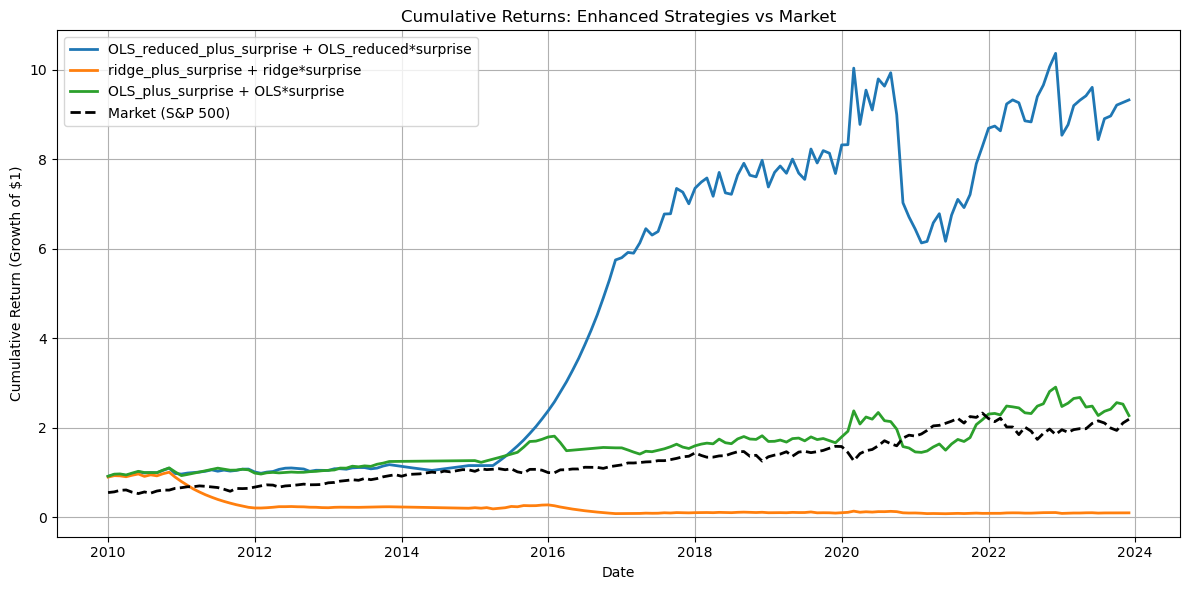

In [71]:
# === Plot Cumulative Returns of All Mixed-Enhanced Strategies vs Market ===
import matplotlib.pyplot as plt

# Define model names and their display labels
mixed_models = ["ols_reduced_enhanced_mix", "ridge_enhanced_mix", "ols_enhanced_mix"]
model_labels = {
    "ols_reduced_enhanced_mix": "OLS_reduced_plus_surprise + OLS_reduced*surprise",
    "ridge_enhanced_mix": "ridge_plus_surprise + ridge*surprise",
    "ols_enhanced_mix": "OLS_plus_surprise + OLS*surprise"
}

cumret_df = None  # Container for merged cumulative return data

for model in mixed_models:
    # Construct long-short portfolio
    portfolio_df = dynamic_equal_weight_portfolio(df, model)
    long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"])["stock_exret"].mean()
    short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"])["stock_exret"].mean()

    # Calculate long-short monthly return
    monthly_port = pd.DataFrame({
        "year": long_ret.index.get_level_values(0),
        "month": long_ret.index.get_level_values(1),
        f"{model}_ret": long_ret.values - short_ret.values
    })
    monthly_port["yyyymm"] = monthly_port["year"] * 100 + monthly_port["month"]
    monthly_port = monthly_port.merge(benchmark, left_on="yyyymm", right_index=True)

    # Convert to datetime for plotting
    monthly_port["date"] = pd.to_datetime(
        monthly_port["year_x"].astype(str) + "-" + monthly_port["month_x"].astype(str) + "-01"
    )
    monthly_port = monthly_port.sort_values("date")

    # Compute cumulative return series
    monthly_port[f"{model}_cum"] = (1 + monthly_port[f"{model}_ret"]).cumprod()

    # Merge with master DataFrame
    if cumret_df is None:
        cumret_df = monthly_port[["date", f"{model}_cum"]].copy()
    else:
        cumret_df = cumret_df.merge(monthly_port[["date", f"{model}_cum"]], on="date", how="outer")

# Compute market cumulative return
benchmark["date"] = pd.to_datetime(benchmark["year"].astype(str) + "-" + benchmark["month"].astype(str) + "-01")
benchmark = benchmark.sort_values("date")
benchmark["market_cum"] = (1 + benchmark["mkt_rf"]).cumprod()
cumret_df = cumret_df.merge(benchmark[["date", "market_cum"]], on="date", how="left")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
for model in mixed_models:
    plt.plot(cumret_df["date"], cumret_df[f"{model}_cum"], label=model_labels[model], linewidth=2)
plt.plot(cumret_df["date"], cumret_df["market_cum"], label="Market (S&P 500)", linestyle="--", color="black", linewidth=2)

plt.title("Cumulative Returns: Enhanced Strategies vs Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Growth of $1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model ols_reduced_enhanced_mix: Dynamic threshold = 0.0405


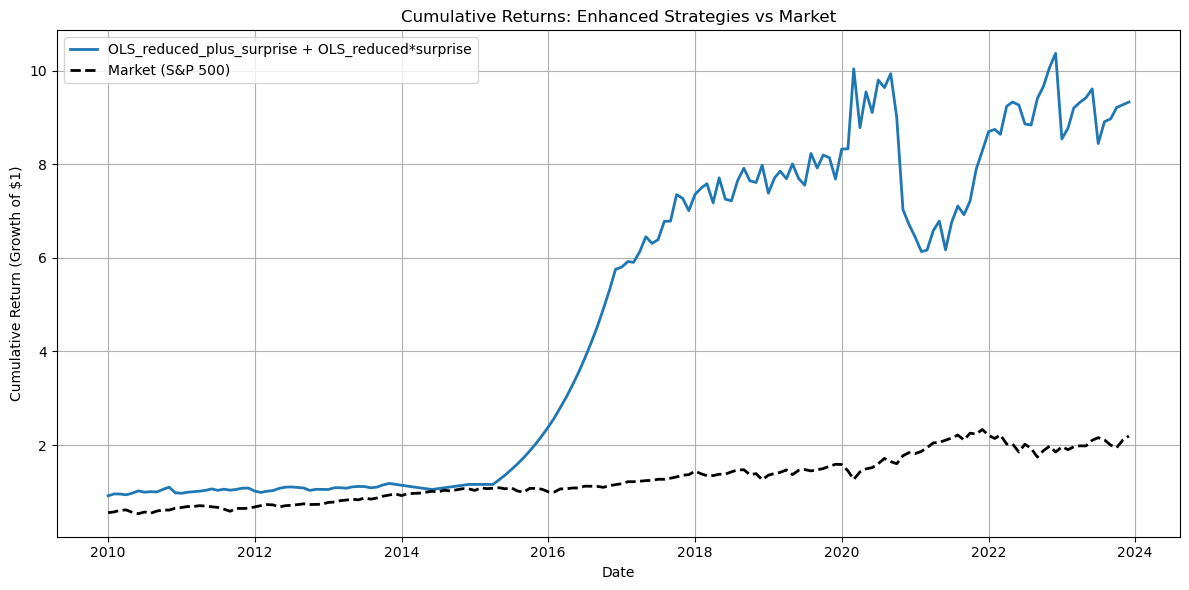

In [87]:
# === Plot Cumulative Returns of All Mixed-Enhanced Strategies vs Market ===
import matplotlib.pyplot as plt

# Define model names and their display labels
mixed_models = ["ols_reduced_enhanced_mix"]
model_labels = {
    "ols_reduced_enhanced_mix": "OLS_reduced_plus_surprise + OLS_reduced*surprise",
}

cumret_df = None  # Container for merged cumulative return data

for model in mixed_models:
    # Construct long-short portfolio
    portfolio_df = dynamic_equal_weight_portfolio(df, model)
    long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"])["stock_exret"].mean()
    short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"])["stock_exret"].mean()

    # Calculate long-short monthly return
    monthly_port = pd.DataFrame({
        "year": long_ret.index.get_level_values(0),
        "month": long_ret.index.get_level_values(1),
        f"{model}_ret": long_ret.values - short_ret.values
    })
    monthly_port["yyyymm"] = monthly_port["year"] * 100 + monthly_port["month"]
    monthly_port = monthly_port.merge(benchmark, left_on="yyyymm", right_index=True)

    # Convert to datetime for plotting
    monthly_port["date"] = pd.to_datetime(
        monthly_port["year_x"].astype(str) + "-" + monthly_port["month_x"].astype(str) + "-01"
    )
    monthly_port = monthly_port.sort_values("date")

    # Compute cumulative return series
    monthly_port[f"{model}_cum"] = (1 + monthly_port[f"{model}_ret"]).cumprod()

    # Merge with master DataFrame
    if cumret_df is None:
        cumret_df = monthly_port[["date", f"{model}_cum"]].copy()
    else:
        cumret_df = cumret_df.merge(monthly_port[["date", f"{model}_cum"]], on="date", how="outer")

# Compute market cumulative return
benchmark["date"] = pd.to_datetime(benchmark["year"].astype(str) + "-" + benchmark["month"].astype(str) + "-01")
benchmark = benchmark.sort_values("date")
benchmark["market_cum"] = (1 + benchmark["mkt_rf"]).cumprod()
cumret_df = cumret_df.merge(benchmark[["date", "market_cum"]], on="date", how="left")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
for model in mixed_models:
    plt.plot(cumret_df["date"], cumret_df[f"{model}_cum"], label=model_labels[model], linewidth=2)
plt.plot(cumret_df["date"], cumret_df["market_cum"], label="Market (S&P 500)", linestyle="--", color="black", linewidth=2)

plt.title("Cumulative Returns: Enhanced Strategies vs Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Growth of $1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
# Define enhanced signal
def build_mixed_enhanced_score(df, ret_col, surprise_col, w_add=0.7, w_mul=0.3):
    enhanced = df[ret_col].copy()
    mask = df[surprise_col].notna()
    enhanced[mask] = (
        w_add * (df.loc[mask, ret_col] + df.loc[mask, surprise_col]) +
        w_mul * (df.loc[mask, ret_col] * df.loc[mask, surprise_col])
    )
    return enhanced

df["ols_reduced_enhanced_mix"] = build_mixed_enhanced_score(df, "ols_reduced", "pred_surprise")

# Extract both long and short legs
def extract_long_short(df, model):
    portfolio_list = []
    spread_list = []

    for (y, m), df_month in df.groupby(["year", "month"]):
        df_month = df_month.dropna(subset=[model, "stock_exret"])
        if len(df_month) < 100:
            continue
        top50 = df_month[model].nlargest(50)
        bottom50 = df_month[model].nsmallest(50)
        spread = top50.mean() - bottom50.mean()
        spread_list.append(spread)

    threshold = np.percentile(spread_list, 20)

    for (y, m), df_month in df.groupby(["year", "month"]):
        df_month = df_month.dropna(subset=[model, "stock_exret"]).sort_values(model)
        if len(df_month) < 100:
            continue
        spread = df_month[model].nlargest(50).mean() - df_month[model].nsmallest(50).mean()

        if spread >= threshold:
            long_leg = df_month.iloc[-50:].copy()
            long_leg["side"] = "long"
            short_leg = df_month.iloc[:50].copy()
            short_leg["side"] = "short"
            portfolio = pd.concat([long_leg, short_leg])
            portfolio["year"] = y
            portfolio["month"] = m
            portfolio_list.append(portfolio)

    return pd.concat(portfolio_list, ignore_index=True)

# Apply to model
portfolio_df = extract_long_short(df, "ols_reduced_enhanced_mix")

# Top 10 long-leg holdings
top_long = (
    portfolio_df[portfolio_df["side"] == "long"]["permno"]
    .value_counts()
    .head(10)
    .reset_index()
    .rename(columns={"index": "permno", "permno": "num_months_in_long"})
)

# Top 10 short-leg holdings
top_short = (
    portfolio_df[portfolio_df["side"] == "short"]["permno"]
    .value_counts()
    .head(10)
    .reset_index()
    .rename(columns={"index": "permno", "permno": "num_months_in_short"})
)

# Print results
print("Top 10 Long-Leg Holdings:")
display(top_long)
print("\nTop 10 Short-Leg Holdings:")
display(top_short)

Top 10 Long-Leg Holdings:


,num_months_in_long,count
0,14593,63
1,91233,55
2,64194,52
3,48506,50
4,86580,50
5,85621,49
6,85663,48
7,48486,47
8,76795,46
9,11533,43



Top 10 Short-Leg Holdings:


,num_months_in_short,count
0,91968,77
1,79859,68
2,12073,60
3,50017,44
4,22517,41
5,12558,41
6,80072,41
7,60599,39
8,36397,38
9,52898,37


## Market Value Weighted

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

# === Define model list (columns in prediction file) ===
models = ["ols", "ols_reduced", "lasso", "ridge", "xgb", "ae_ridge"]

# === Load data ===
# Replace these paths with your actual file locations
pred = pd.read_csv("../results/prediction_results.csv")   # must include 'year', 'month', 'permno', 'stock_exret', all model scores
mkt = pd.read_csv("../data/raw/mkt_ind.csv")              # should include 'year', 'month', 'rf'
hsb = pd.read_csv("../data/raw/mma_sample_v2.csv")[["year", "month", "permno", "market_equity"]]

# === Merge market equity into prediction table ===
pred = pred.merge(hsb, on=["year", "month", "permno"], how="left")

# === Loop through models and evaluate strategy ===
for model in models:
    print(f"\n=== Evaluating model: {model} ===")

    # === Select top and bottom 50 each month ===
    def construct_fixed_portfolio(df_month):
        df_month = df_month.dropna(subset=[model, "stock_exret", "market_equity"]).sort_values(model)
        if len(df_month) < 100:
            return pd.DataFrame()
        long_leg = df_month.iloc[-50:].copy()
        long_leg["side"] = "long"
        short_leg = df_month.iloc[:50].copy()
        short_leg["side"] = "short"
        return pd.concat([long_leg, short_leg])

    portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)

    # === Value-weighted return calculation ===
    def weighted_return(group):
        weights = group["market_equity"] / group["market_equity"].sum()
        return np.sum(weights * group["stock_exret"])

    long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(weighted_return)
    short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(weighted_return)

    monthly_port = pd.DataFrame({
        "year": long_ret.index.get_level_values(0),
        "month": long_ret.index.get_level_values(1),
        "port_11": long_ret.values - short_ret.values
    })

    # === Merge with market factor ===
    monthly_port = monthly_port.merge(mkt, how="inner", on=["year", "month"])

    # === Run CAPM regression with HAC standard errors ===
    nw_ols = sm.ols(formula="port_11 ~ rf", data=monthly_port).fit(
        cov_type="HAC", cov_kwds={"maxlags": 3}, use_t=True
    )

    # === Output performance metrics ===
    sharpe = monthly_port["port_11"].mean() / monthly_port["port_11"].std() * np.sqrt(12)
    alpha = nw_ols.params["Intercept"]
    alpha_t = nw_ols.tvalues["Intercept"]
    ir = alpha / np.sqrt(nw_ols.mse_resid) * np.sqrt(12)

    # === Max drawdown and worst month ===
    monthly_port["log_port_11"] = np.log(monthly_port["port_11"] + 1)
    monthly_port["cumsum_log_port_11"] = monthly_port["log_port_11"].cumsum()
    peak = monthly_port["cumsum_log_port_11"].cummax()
    drawdown = peak - monthly_port["cumsum_log_port_11"]
    max_dd = drawdown.max()
    max_loss = monthly_port["port_11"].min()

    # === Print results ===
    print("Sharpe Ratio:", sharpe)
    print(nw_ols.summary())
    print("CAPM Alpha:", alpha)
    print("t-statistic:", alpha_t)
    print("Information Ratio:", ir)
    print("Max Drawdown:", max_dd)
    print("Max Monthly Loss:", max_loss)


=== Evaluating model: ols ===


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1219461414.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1219461414.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).a

Sharpe Ratio: 0.1653202167987205
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.370
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.243
Time:                        14:26:54   Log-Likelihood:                 249.67
No. Observations:                 168   AIC:                            -495.3
Df Residuals:                     166   BIC:                            -489.1
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.00

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1219461414.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1219461414.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).a

Sharpe Ratio: 0.27071230175477184
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1476
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.701
Time:                        14:26:55   Log-Likelihood:                 263.66
No. Observations:                 168   AIC:                            -523.3
Df Residuals:                     166   BIC:                            -517.1
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1219461414.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1219461414.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).a

Sharpe Ratio: -0.29240139314613256
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.523
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.219
Time:                        14:26:55   Log-Likelihood:                 253.00
No. Observations:                 168   AIC:                            -502.0
Df Residuals:                     166   BIC:                            -495.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1219461414.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1219461414.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).a

Sharpe Ratio: 0.28514543891694205
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.02492
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.875
Time:                        14:26:55   Log-Likelihood:                 241.83
No. Observations:                 168   AIC:                            -479.7
Df Residuals:                     166   BIC:                            -473.4
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1219461414.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1219461414.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).a

Sharpe Ratio: -0.18131496931663138
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4150
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.520
Time:                        14:26:56   Log-Likelihood:                 246.35
No. Observations:                 168   AIC:                            -488.7
Df Residuals:                     166   BIC:                            -482.4
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1219461414.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1219461414.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).a

In [12]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

# === Model list ===
models = ["ols", "ols_reduced", "lasso", "ridge", "xgb", "ae_ridge"]

# === Load data ===
pred = pd.read_csv("../results/prediction_results.csv")
mkt = pd.read_csv("../data/raw/mkt_ind.csv")
hsb = pd.read_csv("../data/raw/mma_sample_v2.csv")[["year", "month", "permno", "market_equity"]]

mkt["mkt_rf"] = mkt["sp_ret"] - mkt["rf"]

# === Merge market equity ===
pred = pred.merge(hsb, on=["year", "month", "permno"], how="left")

# === Size-neutral weighted return function ===
def size_neutral_return(group, alpha=0.5):
    weights = 1 / (group["market_equity"] ** alpha)
    weights = weights / weights.sum()
    return np.sum(weights * group["stock_exret"])

# === Backtest loop ===
for model in models:
    print(f"\n=== Evaluating model: {model} (size-neutral alpha=0.5) ===")

    def construct_fixed_portfolio(df_month):
        df_month = df_month.dropna(subset=[model, "stock_exret", "market_equity"]).sort_values(model)
        if len(df_month) < 100:
            return pd.DataFrame()
        long_leg = df_month.iloc[-50:].copy()
        long_leg["side"] = "long"
        short_leg = df_month.iloc[:50].copy()
        short_leg["side"] = "short"
        return pd.concat([long_leg, short_leg])

    portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)

    long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
        lambda g: size_neutral_return(g, alpha=0.3)
    )
    short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(
        lambda g: size_neutral_return(g, alpha=0.3)
    )

    monthly_port = pd.DataFrame({
        "year": long_ret.index.get_level_values(0),
        "month": long_ret.index.get_level_values(1),
        "port_11": long_ret.values - short_ret.values
    })

    monthly_port = monthly_port.merge(mkt, how="inner", on=["year", "month"])

    # CAPM with HAC standard errors
    nw_ols = sm.ols(formula="port_11 ~ mkt_rf", data=monthly_port).fit(
        cov_type="HAC", cov_kwds={"maxlags": 3}, use_t=True
    )

    # Performance metrics
    sharpe = monthly_port["port_11"].mean() / monthly_port["port_11"].std() * np.sqrt(12)
    alpha = nw_ols.params["Intercept"]
    alpha_t = nw_ols.tvalues["Intercept"]
    ir = alpha / np.sqrt(nw_ols.mse_resid) * np.sqrt(12)

    monthly_port["log_port_11"] = np.log(monthly_port["port_11"] + 1)
    monthly_port["cumsum_log_port_11"] = monthly_port["log_port_11"].cumsum()
    peak = monthly_port["cumsum_log_port_11"].cummax()
    drawdown = peak - monthly_port["cumsum_log_port_11"]
    max_dd = drawdown.max()
    max_loss = monthly_port["port_11"].min()

    # Print result
    print("Sharpe Ratio:", sharpe)
    print(nw_ols.summary())
    print("CAPM Alpha:", alpha)
    print("t-statistic:", alpha_t)
    print("Information Ratio:", ir)
    print("Max Drawdown:", max_dd)
    print("Max Monthly Loss:", max_loss)


=== Evaluating model: ols (size-neutral alpha=0.5) ===


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\174867779.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\174867779.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).app

Sharpe Ratio: 0.43375205771960157
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1116
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.739
Time:                        16:22:18   Log-Likelihood:                 268.52
No. Observations:                 168   AIC:                            -533.0
Df Residuals:                     166   BIC:                            -526.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\174867779.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\174867779.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).app

Sharpe Ratio: 0.5673541475303646
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4.466
Date:                Sun, 25 May 2025   Prob (F-statistic):             0.0361
Time:                        16:22:18   Log-Likelihood:                 269.93
No. Observations:                 168   AIC:                            -535.9
Df Residuals:                     166   BIC:                            -529.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.00

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\174867779.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\174867779.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).app

Sharpe Ratio: -0.5711979020108354
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.637
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.203
Time:                        16:22:19   Log-Likelihood:                 293.51
No. Observations:                 168   AIC:                            -583.0
Df Residuals:                     166   BIC:                            -576.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\174867779.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\174867779.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).app

Sharpe Ratio: 0.46549473965491805
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.562
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.213
Time:                        16:22:19   Log-Likelihood:                 254.43
No. Observations:                 168   AIC:                            -504.9
Df Residuals:                     166   BIC:                            -498.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\174867779.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\174867779.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).app

Sharpe Ratio: 0.13451998402133208
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.587
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.210
Time:                        16:22:20   Log-Likelihood:                 274.78
No. Observations:                 168   AIC:                            -545.6
Df Residuals:                     166   BIC:                            -539.3
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\174867779.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = pred.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\174867779.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).app

In [11]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

# === Load data ===
df = pd.read_csv("../results/prediction_results.csv")
mkt = pd.read_csv("../data/raw/mkt_ind.csv")  # includes 'year', 'month', 'rf'
hsb = pd.read_csv("../data/raw/mma_sample_v2.csv")[["year", "month", "permno", "market_equity"]]

df = df.merge(hsb, on=["year", "month", "permno"], how="left")

mkt["mkt_rf"] = mkt["sp_ret"] - mkt["rf"]

# === Enhanced score logic ===
def build_enhanced_score(df, ret_col, surprise_col):
    enhanced = df[ret_col].copy()
    mask = df[surprise_col].notna()
    enhanced[mask] = 0.7 * df.loc[mask, ret_col] + 0.3 * df.loc[mask, ret_col] * df.loc[mask, surprise_col]
    return enhanced

df["ols_reduced_enhanced"] = build_enhanced_score(df, "ols_reduced", "pred_surprise")
df["ridge_enhanced"]       = build_enhanced_score(df, "ridge", "pred_surprise")
df["ols_enhanced"]         = build_enhanced_score(df, "ols", "pred_surprise")

models = ["ols_reduced", "ridge", "ols",
          "ols_reduced_enhanced", "ridge_enhanced", "ols_enhanced"]

# === Weighted return calculation ===
def size_neutral_return(group, alpha=0.5):
    weights = 1 / (group["market_equity"] ** alpha)
    weights = weights / weights.sum()
    return np.sum(weights * group["stock_exret"])

results = []

for model in models:
    print(f"\n=== Evaluating model: {model} ===")

    def construct_fixed_portfolio(df_month):
        df_month = df_month.dropna(subset=[model, "stock_exret", "market_equity"]).sort_values(model)
        if len(df_month) < 100:
            return pd.DataFrame()
        long_leg = df_month.iloc[-50:].copy()
        long_leg["side"] = "long"
        short_leg = df_month.iloc[:50].copy()
        short_leg["side"] = "short"
        return pd.concat([long_leg, short_leg])

    portfolio_df = df.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)

    long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
        lambda g: size_neutral_return(g, alpha=0.5)
    )
    short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(
        lambda g: size_neutral_return(g, alpha=0.5)
    )

    monthly_port = pd.DataFrame({
        "year": long_ret.index.get_level_values(0),
        "month": long_ret.index.get_level_values(1),
        "port_11": long_ret.values - short_ret.values
    })

    monthly_port = monthly_port.merge(mkt, on=["year", "month"], how="inner")

    nw_ols = sm.ols("port_11 ~ mkt_rf", data=monthly_port).fit(
        cov_type="HAC", cov_kwds={"maxlags": 3}, use_t=True
    )

    sharpe = monthly_port["port_11"].mean() / monthly_port["port_11"].std() * np.sqrt(12)
    alpha = nw_ols.params["Intercept"]
    alpha_t = nw_ols.tvalues["Intercept"]
    ir = alpha / np.sqrt(nw_ols.mse_resid) * np.sqrt(12)

    monthly_port["log_port_11"] = np.log(monthly_port["port_11"] + 1)
    monthly_port["cumsum_log_port_11"] = monthly_port["log_port_11"].cumsum()
    peak = monthly_port["cumsum_log_port_11"].cummax()
    drawdown = peak - monthly_port["cumsum_log_port_11"]
    max_dd = drawdown.max()
    max_loss = monthly_port["port_11"].min()

    results.append({
        "Model": model,
        "Sharpe": sharpe,
        "Alpha": alpha,
        "Alpha t-stat": alpha_t,
        "IR": ir,
        "Max Drawdown": max_dd,
        "Max Monthly Loss": max_loss
    })

# === Summary output ===
results_df = pd.DataFrame(results)
print("\n=== Summary Table ===")
print(results_df.round(4))


=== Evaluating model: ols_reduced ===


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1893980053.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = df.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1893980053.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).app


=== Evaluating model: ridge ===


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1893980053.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = df.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1893980053.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).app


=== Evaluating model: ols ===


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1893980053.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = df.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1893980053.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).app


=== Evaluating model: ols_reduced_enhanced ===


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1893980053.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = df.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1893980053.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).app


=== Evaluating model: ridge_enhanced ===


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1893980053.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = df.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1893980053.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).app


=== Evaluating model: ols_enhanced ===

=== Summary Table ===
                  Model  Sharpe   Alpha  Alpha t-stat      IR  Max Drawdown  \
0           ols_reduced  0.5763  0.0068        1.5378  0.4684        0.5358   
1                 ridge  0.4666  0.0085        1.6826  0.5394        0.7880   
2                   ols  0.4540  0.0063        1.4906  0.4338        0.5571   
3  ols_reduced_enhanced  0.4692  0.0055        1.1931  0.3687        0.6024   
4        ridge_enhanced  0.0163  0.0030        0.7012  0.2014        1.0795   
5          ols_enhanced  0.4445  0.0062        1.4696  0.4278        0.5530   

   Max Monthly Loss  
0           -0.1740  
1           -0.1249  
2           -0.1774  
3           -0.1761  
4           -0.1448  
5           -0.1807  


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1893980053.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_df = df.groupby(["year", "month"], group_keys=False).apply(construct_fixed_portfolio)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1893980053.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).app

In [10]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

# === Load data with your custom path ===
df = pd.read_csv("../results/prediction_results.csv")
mkt = pd.read_csv("../data/raw/mkt_ind.csv")  # must include 'year', 'month', 'rf'
hsb = pd.read_csv("../data/raw/mma_sample_v2.csv")[["year", "month", "permno", "market_equity"]]
df = df.merge(hsb, on=["year", "month", "permno"], how="left")

mkt["mkt_rf"] = mkt["sp_ret"] - mkt["rf"]

# === Surprise-enhanced scoring ===
def build_enhanced_score(df, ret_col, surprise_col):
    enhanced = df[ret_col].copy()
    mask = df[surprise_col].notna()
    enhanced[mask] = 0.7 * df.loc[mask, ret_col] + 0.3 * df.loc[mask, ret_col] * df.loc[mask, surprise_col]
    return enhanced

df["ols_reduced_enhanced"] = build_enhanced_score(df, "ols_reduced", "pred_surprise")
df["ridge_enhanced"] = build_enhanced_score(df, "ridge", "pred_surprise")
df["ols_enhanced"] = build_enhanced_score(df, "ols", "pred_surprise")

models = ["ols_reduced", "ridge", "ols",
          "ols_reduced_enhanced", "ridge_enhanced", "ols_enhanced"]

# === Size-neutral weighted return ===
def size_neutral_return(group, alpha=0.5):
    weights = 1 / (group["market_equity"] ** alpha)
    weights = weights / weights.sum()
    return np.sum(weights * group["stock_exret"])

# === Dynamic portfolio: force init, skip low-spread ===
def dynamic_portfolio(df, model, threshold=0.05):
    portfolio_list = []
    last_portfolio = None
    first_built = False

    for (y, m), df_month in df.groupby(["year", "month"]):
        df_month = df_month.dropna(subset=[model, "stock_exret", "market_equity"]).sort_values(model)
        if len(df_month) < 100:
            continue

        spread = df_month[model].nlargest(50).mean() - df_month[model].nsmallest(50).mean()

        if not first_built or spread >= threshold:
            long_leg = df_month.iloc[-50:].copy()
            long_leg["side"] = "long"
            short_leg = df_month.iloc[:50].copy()
            short_leg["side"] = "short"
            long_short = pd.concat([long_leg, short_leg])
            long_short["year"] = y
            long_short["month"] = m
            portfolio_list.append(long_short)
            last_portfolio = long_short.copy()
            first_built = True
        else:
            reused = last_portfolio.copy()
            reused["year"] = y
            reused["month"] = m
            portfolio_list.append(reused)

    return pd.concat(portfolio_list, ignore_index=True)

# === Backtest loop ===
results = []

for model in models:
    print(f"\n=== Evaluating model with dynamic position: {model} ===")
    portfolio_df = dynamic_portfolio(df, model, threshold=0.05)

    long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
        lambda g: size_neutral_return(g, alpha=0.5)
    )
    short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(
        lambda g: size_neutral_return(g, alpha=0.5)
    )

    monthly_port = pd.DataFrame({
        "year": long_ret.index.get_level_values(0),
        "month": long_ret.index.get_level_values(1),
        "port_11": long_ret.values - short_ret.values
    })

    monthly_port = monthly_port.merge(mkt, how="inner", on=["year", "month"])

    nw_ols = sm.ols("port_11 ~ mkt_rf", data=monthly_port).fit(cov_type="HAC", cov_kwds={"maxlags": 3}, use_t=True)
    sharpe = monthly_port["port_11"].mean() / monthly_port["port_11"].std() * np.sqrt(12)
    alpha = nw_ols.params["Intercept"]
    alpha_t = nw_ols.tvalues["Intercept"]
    ir = alpha / np.sqrt(nw_ols.mse_resid) * np.sqrt(12)

    monthly_port["log_port_11"] = np.log(monthly_port["port_11"] + 1)
    monthly_port["cumsum_log_port_11"] = monthly_port["log_port_11"].cumsum()
    peak = monthly_port["cumsum_log_port_11"].cummax()
    drawdown = peak - monthly_port["cumsum_log_port_11"]
    max_dd = drawdown.max()
    max_loss = monthly_port["port_11"].min()

    results.append({
        "Model": model,
        "Sharpe": sharpe,
        "Alpha": alpha,
        "Alpha t-stat": alpha_t,
        "IR": ir,
        "Max Drawdown": max_dd,
        "Max Monthly Loss": max_loss
    })

# === Output summary ===
results_df = pd.DataFrame(results)
print("\n=== Strategy Performance Summary ===")
print(results_df.round(4))



=== Evaluating model with dynamic position: ols_reduced ===


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1494377718.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1494377718.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(



=== Evaluating model with dynamic position: ridge ===


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1494377718.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1494377718.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(



=== Evaluating model with dynamic position: ols ===


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1494377718.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1494377718.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(



=== Evaluating model with dynamic position: ols_reduced_enhanced ===


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1494377718.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1494377718.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(



=== Evaluating model with dynamic position: ridge_enhanced ===


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1494377718.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1494377718.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(



=== Evaluating model with dynamic position: ols_enhanced ===

=== Strategy Performance Summary ===
                  Model        Sharpe   Alpha  Alpha t-stat            IR  \
0           ols_reduced  5.030000e-02  0.0003  4.240000e-02  1.750000e-02   
1                 ridge -1.107809e+15 -0.0167 -1.558580e+16 -8.283653e+15   
2                   ols  2.737000e-01  0.0034  6.969000e-01  2.380000e-01   
3  ols_reduced_enhanced -1.945553e+15 -0.0352 -3.284647e+16 -1.745748e+16   
4        ridge_enhanced -1.083544e+15 -0.0120 -1.490566e+16 -7.922166e+15   
5          ols_enhanced  3.640000e-01  0.0037  8.222000e-01  3.508000e-01   

   Max Drawdown  Max Monthly Loss  
0        2.2088           -0.0813  
1        2.8112           -0.0167  
2        1.1030           -0.1774  
3        5.9807           -0.0352  
4        2.0116           -0.0120  
5        0.9157           -0.1189  


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1494377718.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1494377718.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(


In [88]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

# === Your file paths ===
df = pd.read_csv("../results/prediction_results.csv")
mkt = pd.read_csv("../data/raw/mkt_ind.csv")
hsb = pd.read_csv("../data/raw/mma_sample_v2.csv")[["year", "month", "permno", "market_equity"]]
df = df.merge(hsb, on=["year", "month", "permno"], how="left")

mkt["mkt_rf"] = mkt["sp_ret"] - mkt["rf"]

# === Enhanced score function ===
def build_enhanced_score(df, ret_col, surprise_col):
    enhanced = df[ret_col].copy()
    mask = df[surprise_col].notna()
    enhanced[mask] = 1.5 * df.loc[mask, ret_col] + 0.3 * df.loc[mask, ret_col] * df.loc[mask, surprise_col]
    return enhanced

df["ols_reduced_enhanced"] = build_enhanced_score(df, "ols_reduced", "pred_surprise")
df["ridge_enhanced"] = build_enhanced_score(df, "ridge", "pred_surprise")
df["ols_enhanced"] = build_enhanced_score(df, "ols", "pred_surprise")

models = ["ols_reduced", "ridge", "ols",
          "ols_reduced_enhanced", "ridge_enhanced", "ols_enhanced"]

# === Size-neutral return ===
def size_neutral_return(group, alpha=0.5):
    weights = 1 / (group["market_equity"] ** alpha)
    weights = weights / weights.sum()
    return np.sum(weights * group["stock_exret"])

# === Dynamic portfolio builder with model-aware spread threshold ===
def dynamic_portfolio_with_auto_threshold(df, model):
    portfolio_list = []
    last_portfolio = None
    first_built = False
    spread_list = []

    # Step 1: collect spreads
    for (y, m), df_month in df.groupby(["year", "month"]):
        df_month = df_month.dropna(subset=[model, "stock_exret", "market_equity"])
        if len(df_month) < 100:
            continue
        top50 = df_month[model].nlargest(50)
        bottom50 = df_month[model].nsmallest(50)
        spread = top50.mean() - bottom50.mean()
        spread_list.append(spread)

    if not spread_list:
        print(f"Model {model}: No spread data.")
        return pd.DataFrame(columns=df.columns.tolist() + ["side", "year", "month"])

    threshold = np.percentile(spread_list, 20)
    print(f"Model {model}: Dynamic threshold = {threshold:.4f}")

    # Step 2: construct portfolios
    for (y, m), df_month in df.groupby(["year", "month"]):
        df_month = df_month.dropna(subset=[model, "stock_exret", "market_equity"]).sort_values(model)
        if len(df_month) < 100:
            continue
        spread = df_month[model].nlargest(50).mean() - df_month[model].nsmallest(50).mean()

        if not first_built or spread >= threshold:
            long_leg = df_month.iloc[-50:].copy()
            long_leg["side"] = "long"
            short_leg = df_month.iloc[:50].copy()
            short_leg["side"] = "short"
            combined = pd.concat([long_leg, short_leg])
            combined["year"] = y
            combined["month"] = m
            portfolio_list.append(combined)
            last_portfolio = combined.copy()
            first_built = True
        else:
            reused = last_portfolio.copy()
            reused["year"] = y
            reused["month"] = m
            portfolio_list.append(reused)

    return pd.concat(portfolio_list, ignore_index=True)

# === Backtest and evaluation ===
results = []

for model in models:
    print(f"\n=== Evaluating model with dynamic threshold: {model} ===")
    portfolio_df = dynamic_portfolio_with_auto_threshold(df, model)

    long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
        lambda g: size_neutral_return(g, alpha=0.5)
    )
    short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(
        lambda g: size_neutral_return(g, alpha=0.5)
    )

    monthly_port = pd.DataFrame({
        "year": long_ret.index.get_level_values(0),
        "month": long_ret.index.get_level_values(1),
        "port_11": long_ret.values - short_ret.values
    })
    monthly_port = monthly_port.merge(mkt, on=["year", "month"])

    nw_ols = sm.ols("port_11 ~ mkt_rf", data=monthly_port).fit(cov_type="HAC", cov_kwds={"maxlags": 3}, use_t=True)
    sharpe = monthly_port["port_11"].mean() / monthly_port["port_11"].std() * np.sqrt(12)
    alpha = nw_ols.params["Intercept"]
    alpha_t = nw_ols.tvalues["Intercept"]
    ir = alpha / np.sqrt(nw_ols.mse_resid) * np.sqrt(12)

    monthly_port["log_port_11"] = np.log(monthly_port["port_11"] + 1)
    monthly_port["cumsum_log_port_11"] = monthly_port["log_port_11"].cumsum()
    peak = monthly_port["cumsum_log_port_11"].cummax()
    drawdown = peak - monthly_port["cumsum_log_port_11"]
    max_dd = drawdown.max()
    max_loss = monthly_port["port_11"].min()

    # Annualized return and std (based on total portfolio return)
    avg_ret = monthly_port["port_11"].mean()
    std_ret = monthly_port["port_11"].std()
    ann_return = avg_ret * 12
    ann_vol = std_ret * np.sqrt(12)

    # Turnover: percent of new stocks each month
    turnover_list = []
    last_set = set()
    for (y, m), df_month in portfolio_df.groupby(["year", "month"]):
        current_set = set(df_month["permno"])
        if last_set:
            turnover = 1 - len(current_set & last_set) / 100  # fixed 100 stock size
            turnover_list.append(turnover)
        last_set = current_set
    avg_turnover = np.mean(turnover_list)


    results.append({
        "Model": model,
        "Sharpe": sharpe,
        "Alpha": alpha,
        "Alpha (Annualized)": alpha * 12,
        "Alpha t-stat": alpha_t,
        "IR": ir,
        "Annualized Return": ann_return,
        "Annualized Vol": ann_vol,
        "Turnover": avg_turnover,
        "Max Drawdown": max_dd,
        "Max Monthly Loss": max_loss
    })

# === Output
results_df = pd.DataFrame(results)
print("\n=== Strategy Performance Summary ===")
print(results_df.round(4))


=== Evaluating model with dynamic threshold: ols_reduced ===
Model ols_reduced: Dynamic threshold = 0.0300


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2674741363.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2674741363.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(



=== Evaluating model with dynamic threshold: ridge ===
Model ridge: Dynamic threshold = 0.0011


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2674741363.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2674741363.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(



=== Evaluating model with dynamic threshold: ols ===
Model ols: Dynamic threshold = 0.0455


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2674741363.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2674741363.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(



=== Evaluating model with dynamic threshold: ols_reduced_enhanced ===
Model ols_reduced_enhanced: Dynamic threshold = 0.0449


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2674741363.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2674741363.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(



=== Evaluating model with dynamic threshold: ridge_enhanced ===
Model ridge_enhanced: Dynamic threshold = 0.0023


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2674741363.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2674741363.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(



=== Evaluating model with dynamic threshold: ols_enhanced ===
Model ols_enhanced: Dynamic threshold = 0.0682

=== Strategy Performance Summary ===
                  Model  Sharpe   Alpha  Alpha (Annualized)  Alpha t-stat  \
0           ols_reduced  0.6566  0.0089              0.1065        1.7178   
1                 ridge  0.6132  0.0100              0.1197        2.1562   
2                   ols  0.7301  0.0100              0.1197        2.5046   
3  ols_reduced_enhanced  0.6274  0.0084              0.1014        1.6635   
4        ridge_enhanced  0.9647  0.0146              0.1750        3.3671   
5          ols_enhanced  0.7329  0.0099              0.1190        2.6002   

       IR  Annualized Return  Annualized Vol  Turnover  Max Drawdown  \
0  0.5588             0.1261          0.1920    0.4266        0.6580   
1  0.6908             0.1065          0.1737    0.3713        0.5797   
2  0.7189             0.1212          0.1660    0.4549        0.3051   
3  0.5302             0.

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2674741363.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2674741363.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(


Model ols_reduced: Dynamic threshold = 0.0300


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2820239972.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2820239972.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(


Model ridge: Dynamic threshold = 0.0011


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2820239972.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2820239972.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(


Model ols: Dynamic threshold = 0.0455


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2820239972.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2820239972.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(


Model ols_reduced_enhanced: Dynamic threshold = 0.0449


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2820239972.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2820239972.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(


Model ridge_enhanced: Dynamic threshold = 0.0023


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2820239972.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2820239972.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(


Model ols_enhanced: Dynamic threshold = 0.0682


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2820239972.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\2820239972.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(


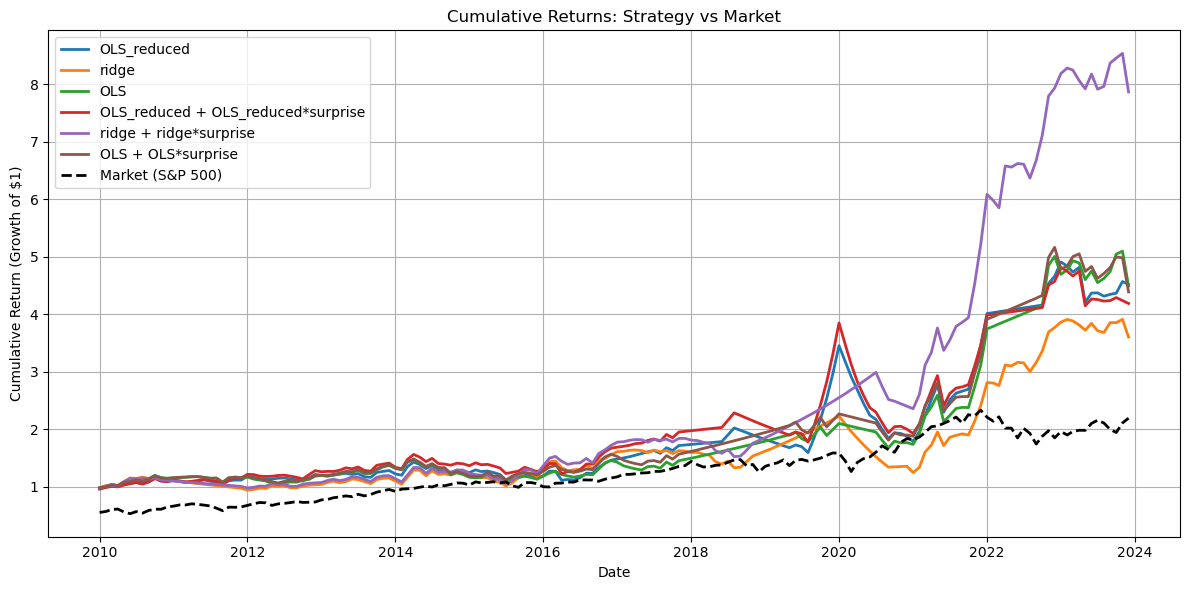

In [74]:
# === Step: Plot Cumulative Returns of All Strategies vs Market ===
import matplotlib.pyplot as plt

# Label for plotting
model_labels = {
    "ols_reduced": "OLS_reduced",
    "ridge": "ridge",
    "ols": "OLS",
    "ols_reduced_enhanced": "OLS_reduced + OLS_reduced*surprise",
    "ridge_enhanced": "ridge + ridge*surprise",
    "ols_enhanced": "OLS + OLS*surprise"
}

# Store cumulative return series
cumret_df = None

for model in models:
    portfolio_df = dynamic_portfolio_with_auto_threshold(df, model)

    long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
        lambda g: size_neutral_return(g, alpha=0.5)
    )
    short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(
        lambda g: size_neutral_return(g, alpha=0.5)
    )

    monthly_port = pd.DataFrame({
        "year": long_ret.index.get_level_values(0),
        "month": long_ret.index.get_level_values(1),
        f"{model}_ret": long_ret.values - short_ret.values
    })
    monthly_port = monthly_port.merge(mkt, on=["year", "month"])

    # Create date column
    monthly_port["date"] = pd.to_datetime(
        monthly_port["year"].astype(str) + "-" + monthly_port["month"].astype(str) + "-01"
    )
    monthly_port = monthly_port.sort_values("date")

    # Compute cumulative return
    monthly_port[f"{model}_cum"] = (1 + monthly_port[f"{model}_ret"]).cumprod()

    if cumret_df is None:
        cumret_df = monthly_port[["date", f"{model}_cum"]].copy()
    else:
        cumret_df = cumret_df.merge(monthly_port[["date", f"{model}_cum"]], on="date", how="outer")

# Add market cumulative return
mkt["date"] = pd.to_datetime(mkt["year"].astype(str) + "-" + mkt["month"].astype(str) + "-01")
mkt = mkt.sort_values("date")
mkt["market_cum"] = (1 + mkt["mkt_rf"]).cumprod()
cumret_df = cumret_df.merge(mkt[["date", "market_cum"]], on="date", how="left")

# Plot
plt.figure(figsize=(12, 6))
for model in models:
    plt.plot(cumret_df["date"], cumret_df[f"{model}_cum"], label=model_labels[model], linewidth=2)
plt.plot(cumret_df["date"], cumret_df["market_cum"], label="Market (S&P 500)", linestyle="--", color="black", linewidth=2)

plt.title("Cumulative Returns: Strategy vs Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Growth of $1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model ridge_enhanced: Dynamic threshold = 0.0023


C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1348471119.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_2800\1348471119.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(


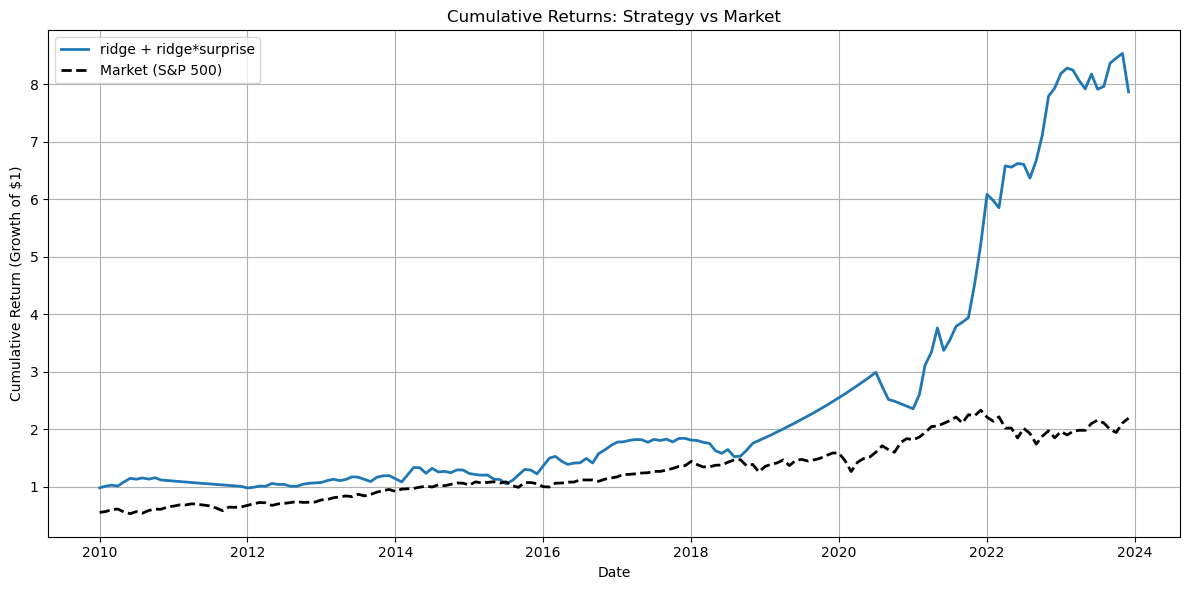

In [90]:
# === Step: Plot Cumulative Returns of All Strategies vs Market ===
import matplotlib.pyplot as plt

models = ["ridge_enhanced"]

# Label for plotting
model_labels = {
    "ridge_enhanced": "ridge + ridge*surprise",
}

# Store cumulative return series
cumret_df = None

for model in models:
    portfolio_df = dynamic_portfolio_with_auto_threshold(df, model)

    long_ret = portfolio_df[portfolio_df["side"] == "long"].groupby(["year", "month"]).apply(
        lambda g: size_neutral_return(g, alpha=0.5)
    )
    short_ret = portfolio_df[portfolio_df["side"] == "short"].groupby(["year", "month"]).apply(
        lambda g: size_neutral_return(g, alpha=0.5)
    )

    monthly_port = pd.DataFrame({
        "year": long_ret.index.get_level_values(0),
        "month": long_ret.index.get_level_values(1),
        f"{model}_ret": long_ret.values - short_ret.values
    })
    monthly_port = monthly_port.merge(mkt, on=["year", "month"])

    # Create date column
    monthly_port["date"] = pd.to_datetime(
        monthly_port["year"].astype(str) + "-" + monthly_port["month"].astype(str) + "-01"
    )
    monthly_port = monthly_port.sort_values("date")

    # Compute cumulative return
    monthly_port[f"{model}_cum"] = (1 + monthly_port[f"{model}_ret"]).cumprod()

    if cumret_df is None:
        cumret_df = monthly_port[["date", f"{model}_cum"]].copy()
    else:
        cumret_df = cumret_df.merge(monthly_port[["date", f"{model}_cum"]], on="date", how="outer")

# Add market cumulative return
mkt["date"] = pd.to_datetime(mkt["year"].astype(str) + "-" + mkt["month"].astype(str) + "-01")
mkt = mkt.sort_values("date")
mkt["market_cum"] = (1 + mkt["mkt_rf"]).cumprod()
cumret_df = cumret_df.merge(mkt[["date", "market_cum"]], on="date", how="left")

# Plot
plt.figure(figsize=(12, 6))
for model in models:
    plt.plot(cumret_df["date"], cumret_df[f"{model}_cum"], label=model_labels[model], linewidth=2)
plt.plot(cumret_df["date"], cumret_df["market_cum"], label="Market (S&P 500)", linestyle="--", color="black", linewidth=2)

plt.title("Cumulative Returns: Strategy vs Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Growth of $1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
# === Enhanced score for ridge_enhanced ===
def build_enhanced_score(df, ret_col, surprise_col):
    enhanced = df[ret_col].copy()
    mask = df[surprise_col].notna()
    enhanced[mask] = 1.5 * df.loc[mask, ret_col] + 0.3 * df.loc[mask, ret_col] * df.loc[mask, surprise_col]
    return enhanced

df["ridge_enhanced"] = build_enhanced_score(df, "ridge", "pred_surprise")

# === Extract long and short positions based on dynamic threshold ===
def extract_long_short(df, model):
    portfolio_list = []
    spread_list = []

    # Step 1: calculate spread history
    for (y, m), df_month in df.groupby(["year", "month"]):
        df_month = df_month.dropna(subset=[model, "stock_exret", "market_equity"])
        if len(df_month) < 100:
            continue
        top50 = df_month[model].nlargest(50)
        bottom50 = df_month[model].nsmallest(50)
        spread = top50.mean() - bottom50.mean()
        spread_list.append(spread)

    # Step 2: get dynamic threshold
    threshold = np.percentile(spread_list, 20)

    # Step 3: select long/short each month based on threshold
    for (y, m), df_month in df.groupby(["year", "month"]):
        df_month = df_month.dropna(subset=[model, "stock_exret", "market_equity"]).sort_values(model)
        if len(df_month) < 100:
            continue
        spread = df_month[model].nlargest(50).mean() - df_month[model].nsmallest(50).mean()

        if spread >= threshold:
            long_leg = df_month.iloc[-50:].copy()
            long_leg["side"] = "long"
            short_leg = df_month.iloc[:50].copy()
            short_leg["side"] = "short"
            combined = pd.concat([long_leg, short_leg])
            combined["year"] = y
            combined["month"] = m
            portfolio_list.append(combined)

    return pd.concat(portfolio_list, ignore_index=True)

# === Run extraction ===
portfolio_df = extract_long_short(df, "ridge_enhanced")

# === Count top 10 permnos for long and short legs ===
top_long = (
    portfolio_df[portfolio_df["side"] == "long"]["permno"]
    .value_counts()
    .head(10)
    .reset_index()
    .rename(columns={"index": "permno", "permno": "num_months_in_long"})
)

top_short = (
    portfolio_df[portfolio_df["side"] == "short"]["permno"]
    .value_counts()
    .head(10)
    .reset_index()
    .rename(columns={"index": "permno", "permno": "num_months_in_short"})
)

# === Output ===
print("Top 10 Long-Leg Holdings:")
display(top_long)

print("\nTop 10 Short-Leg Holdings:")
display(top_short)

Top 10 Long-Leg Holdings:


,num_months_in_long,count
0,27828,104
1,12490,65
2,82598,63
3,40125,63
4,85914,60
5,91461,59
6,27983,57
7,92293,56
8,49373,55
9,16678,55



Top 10 Short-Leg Holdings:


,num_months_in_short,count
0,93436,84
1,67847,72
2,75241,68
3,92239,63
4,86288,61
5,87056,57
6,13641,57
7,90178,55
8,89393,52
9,84723,49
